# 3 - 3D Modeling with GemPy

In [1]:
import sys
import numpy as np
# These two lines are necessary only if gempy is not installed
sys.path.append("../../gempy/")
sys.path.append("../gempy/")

# Importing gempy
import gempy as gp
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

../../gempy/gempy/Visualization.py:31: UserWarning: Vtk package is not installed. No vtk visualization available.
  warnings.warn('Vtk package is not installed. No vtk visualization available.')
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
../../gempy/gempy/UncertaintyAnalysisPYMC2.py:8: UserWarning: pymc (v2) package is not installed. No support for stochastic simulation posterior analysis.
  warnings.warn("pymc (v2) package is not installed. No support for stochastic simulation posterior analysis.")


In [2]:
geo_data=gp.create_data(extent=[612000, 622000, 2472000, 2480000, -1000, 1000], 
                        resolution=[50, 50, 50], 
                        path_f = "../data/gempy_foliations.csv",
                        path_i = "../data/gempy_interfaces.csv")

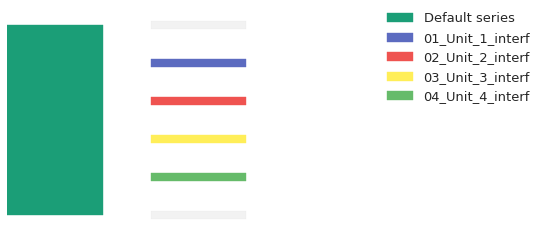

In [3]:
gp.set_series(geo_data, {"Default series": np.unique(geo_data.interfaces["formation"].values)},
             order_formations = np.unique(geo_data.interfaces["formation"].values))

gp.set_order_formations(geo_data, np.unique(geo_data.interfaces["formation"].values))

## 3.2 - Data visualization

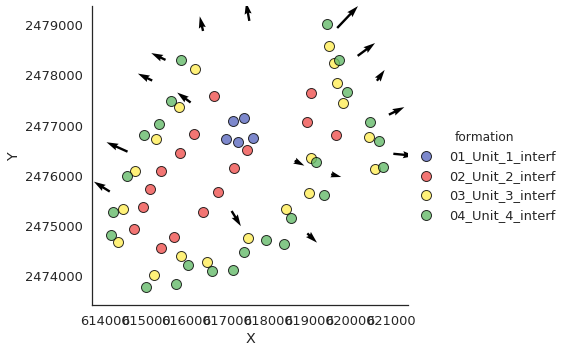

In [4]:
gp.plot_data(geo_data, direction="z")

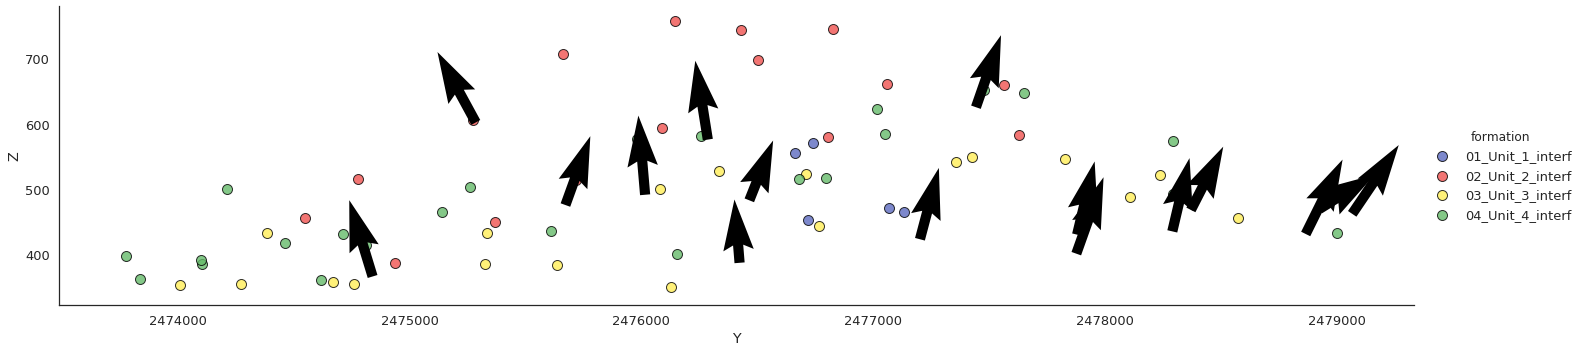

In [5]:
gp.plot_data(geo_data, direction="x")

## 3.3 - Computing the 3D Model

In [6]:
interp_data = gp.InterpolatorInput(geo_data, dtype="float32")

Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32


In [7]:
lith_block, fault_block = gp.compute_model(interp_data)

## 3.4 - Model visualization

### 3.4.1 - 2D Sections

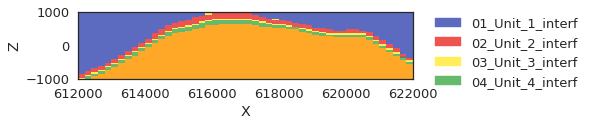

In [8]:
gp.plot_section(geo_data, lith_block[0], 25, direction='y')

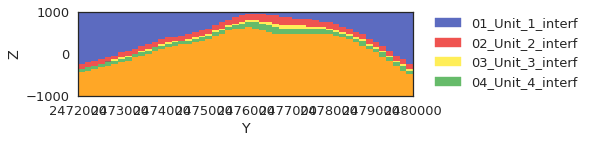

In [9]:
gp.plot_section(geo_data, lith_block[0], 25, direction='x')

### 3.4.2 - Pseudo-3D surfaces

In [10]:
v_l, s_l = gp.get_surfaces(interp_data, potential_lith=lith_block[1], step_size=2)

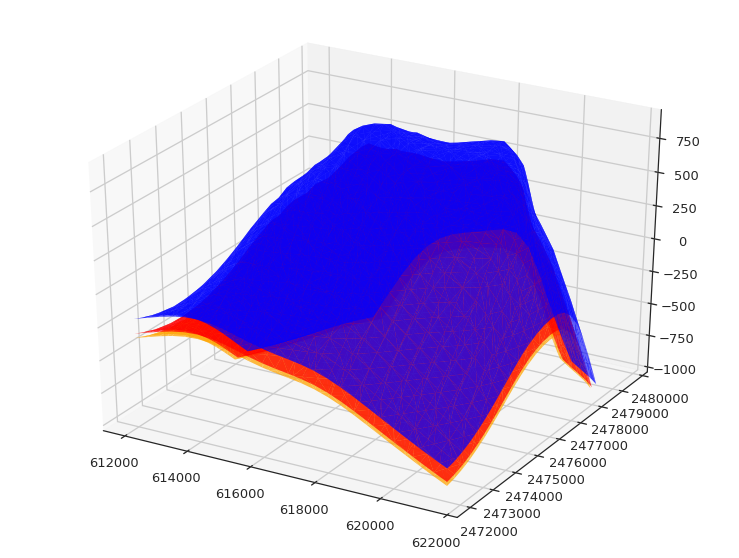

In [11]:
fig = plt.figure(figsize=(13,10))
ax = fig.add_subplot(111, projection='3d')

cs = ["blue", "red", "orange"]



for i in range(3):
    surf = ax.plot_trisurf(v_l[i][:,0], v_l[i][:,1], v_l[i][:,2], 
                           color=cs[i], linewidth=0, alpha=0.75, shade=False)

# Exporting a geological map

In [12]:
import gdal
geotiff_filepath = "../data/dome_sub_sub_utm.tif"
raster = gdal.Open(geotiff_filepath)
dtm = raster.ReadAsArray()

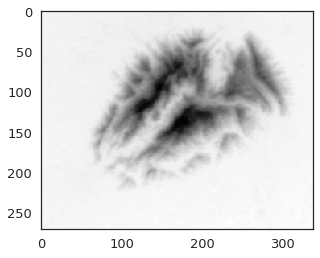

In [13]:
import matplotlib.pyplot as plt
plt.imshow(dtm)
plt.show()

In [16]:
# here are the raster dimensions:
raster.RasterXSize, raster.RasterYSize
geoinformation = raster.GetGeoTransform()

get DTM corners:


In [17]:
dtm_E_min = geoinformation[0]
dtm_E_max = geoinformation[0] + geoinformation[1] * raster.RasterXSize
dtm_N_min = geoinformation[3] + geoinformation[5] * raster.RasterYSize
dtm_N_max = geoinformation[3]
dtm_E_min, dtm_E_max, dtm_N_min, dtm_N_max

(612000.0, 622000.0, 2472000.0, 2480000.0)

In [18]:
# define range for x, y - values
X_range = np.arange(dtm_E_min, dtm_E_max, geoinformation[1])
Y_range = np.arange(dtm_N_min, dtm_N_max, np.abs(geoinformation[5]))
XX, YY = np.meshgrid(X_range, Y_range)

Create list of input points for interpolation with gempy:

In [19]:
points = np.array(list(zip(XX.ravel(), YY.ravel(), dtm.ravel())))

In [20]:
points

array([[  6.12000000e+05,   2.47200000e+06,   3.38000000e+02],
       [  6.12029499e+05,   2.47200000e+06,   3.34000000e+02],
       [  6.12058997e+05,   2.47200000e+06,   3.34000000e+02],
       ..., 
       [  6.21911504e+05,   2.47997048e+06,   2.99000000e+02],
       [  6.21941003e+05,   2.47997048e+06,   2.97000000e+02],
       [  6.21970501e+05,   2.47997048e+06,   2.99000000e+02]])

Build basic gempy using _data_ extent (_resolution_ does not matter, as far as I can tell):

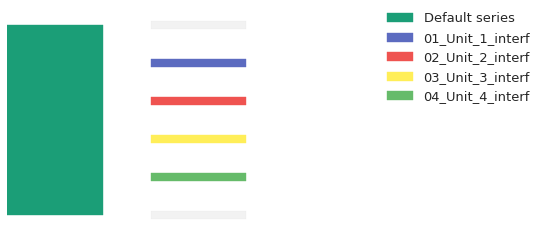

In [21]:
geo_data=gp.create_data(extent=[612000, 622000, 2472000, 2480000, -1000, 1000],  
                        resolution=[1, 1, 1], 
                        path_f = "../data/gempy_foliations.csv",
                        path_i = "../data/gempy_interfaces.csv")

gp.set_series(geo_data, {"Default series": np.unique(geo_data.interfaces["formation"].values)},
             order_formations = np.unique(geo_data.interfaces["formation"].values))

gp.set_order_formations(geo_data, np.unique(geo_data.interfaces["formation"].values))



Now here the "trick": replace grid points with DTM grid points:

In [22]:
geo_data.grid.grid = points

Perform the "usual" interpolation step:

In [23]:
interp_data = gp.InterpolatorInput(geo_data, dtype="float32")
lith_block, fault_block = gp.compute_model(interp_data)

Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32


And here: **the geological map**:

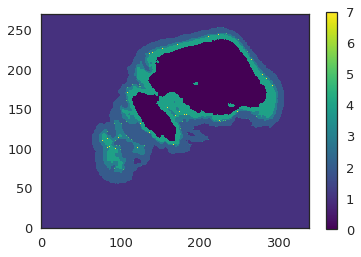

In [24]:
plt.imshow(lith_block[0].reshape((271,339)), cmap='viridis', origin='lower_left')
plt.colorbar()

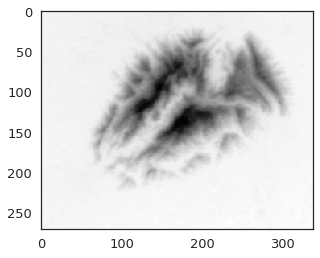

In [25]:
import matplotlib.pyplot as plt
plt.imshow(dtm)
plt.show()

In [26]:
np.min(dtm), np.max(dtm)

(289, 781)